## Import libs and data

In [39]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm, tqdm_notebook, trange
tqdm.pandas()
from collections import Counter
import pickle
import squarify
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
# load dataframe of post and corresponding tokens
df_post = pd.read_csv('../out/car/df_post.csv')

with open('../out/car/tokens_post.txt', 'rb') as fp:
    tokens_post = pickle.load(fp)

df_post['user_id'] = df_post['user_id'].astype(int)

In [3]:
# load user x tag file
df_user_x_cat = pd.read_csv('../src/pantip_user_cat.csv')

In [4]:
df_user_x_cat.head()

,user_id,category,post_date
0,4179868,travel,2018-12-06 21:31:06
1,2897151,travel,2018-12-06 21:19:04
2,772076,travel,2018-12-06 20:52:07
3,4977690,travel,2018-12-06 20:24:25
4,2239672,travel,2018-12-06 20:03:01


In [5]:
df_user_x_cat.category.nunique()

5915

In [6]:
# select top 500 most popular categories
cat_counter = Counter(df_user_x_cat.category.values)

## create tags set and prepare dataframe

In [31]:
# create list of tags
tag_list=[]
for text in df_user_x_cat.category:
    tag_list.append(text.split(', '))

all_tags = []
for tl in tag_list:
    for tag in tl:
        if not tag in all_tags:
            all_tags.append(tag)

In [ ]:
df_tags = pd.DataFrame(np.zeros((len(tag_list),len(all_tags))),columns=all_tags)

for i in tqdm_notebook(range(len(tag_list))):
    for tag in tag_list[i]:
        df_tags.loc[i,tag] = 1

df_tags['user_id'] = df_user_x_cat.user_id.values

df_tags.to_csv('../tmp/df_tags.csv',index=False)

In [7]:
df_tags = pd.read_csv('../tmp/df_tags.csv')

In [8]:
df_user_segment = df_tags.groupby('user_id').sum()
df_user_segment.head()

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
4,3.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0


In [9]:
df_user_segment = df_user_segment.div(df_user_segment.sum(axis=1), axis=0)

## Performing segmentation

In [10]:
# filter unique user id based on kws
kws = ['yaris','ativ']

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break
            
df_temp = df_post.iloc[idxs]

unique_user = df_temp.user_id.unique()

print('total unique user:',len(unique_user))

total unique user: 2210


In [11]:
df_user_segment_filt = df_user_segment.loc[unique_user]

In [12]:
def boxcox_transform(df, skew_thd=1, lmbda_dict=dict(), except_cols=None):
    '''
    Function for performing boxcox transform on DataFrame object with given threshold of feature's
    skewness.
    - Unless except_cols parameter is specified, all features will be considered for the
    transformation.
    - Unless lmbda_dict parameter is specified, suitable lamba for boxcox transform will be used.
    '''
    df_copy=df.copy()
    lambda_dict=lmbda_dict.copy()
    if len(lambda_dict)==0:
        except_cols = cast_none_or_str_to_list(except_cols)
        for col in df_copy.columns:
            if (df_copy[col].skew() > skew_thd) and (col not in except_cols):
                df_copy[col], lamb = stats.boxcox(df_copy[col].values+np.ones_like(df[col]))
                lambda_dict[col] = lamb
    else:
        for col,lamb in lambda_dict.items():
            df_copy[col] = stats.boxcox(df_copy[col].values+np.ones_like(df_copy[col]),lmbda=lamb)
            
    return df_copy, lambda_dict
def cast_none_or_str_to_list(var):
    '''
    This function cast None or str to list.
    '''
    if var==None:
        var=[]
    else:
        if type(var) != list:
            var = [var]
    return var

In [13]:
df_user_segment_filt_tf, tf_param = boxcox_transform(df_user_segment_filt)

In [19]:
sc = StandardScaler()
user_segment_sc = sc.fit_transform(df_user_segment_filt_tf)

## experiment with K-mean clustering

In [20]:
labels = []
wcss = []
for i in range(1,21):
    k_model = KMeans(n_clusters=i,)
    labels.append(k_model.fit_predict(user_segment_sc))
    wcss.append(k_model.inertia_)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

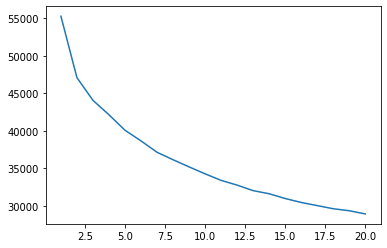

In [22]:
plt.plot(range(1,21),wcss)

In [23]:
label = KMeans(n_clusters=7,).fit_predict(user_segment_sc)

In [27]:
df_user_segment_filt['segment_id'] = label

In [28]:
df_user_segment_filt.segment_id.value_counts()

1    666
5    620
4    342
2    270
3    146
0    128
6     38
Name: segment_id, dtype: int64

In [32]:
'''
NEXT STEP:
describe profile of each segment
'''
# df_user_segment_filt['segment_id'] = label

# summary statistic by segment
df_segment = df_user_segment_filt.groupby('segment_id')[all_tags].mean()

df_user_segment_filt.reset_index(inplace=True)

df_segment = df_segment.join(df_user_segment_filt.groupby('segment_id')['user_id'].count()).rename({'user_id':'total_user'},axis=1)

In [33]:
df_segment

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak,total_user
segment_id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.054806,0.208757,0.022798,0.007727,0.017196,0.012271,0.000000,0.031729,0.106423,0.011093,0.012717,0.028100,0.009711,0.083779,0.006749,0.013686,0.188261,0.046246,0.035112,0.057089,0.016458,0.008902,0.016579,0.003029,0.000782,128
1,0.008787,0.798180,0.003566,0.001295,0.002025,0.005141,0.000000,0.000876,0.012947,0.009802,0.002452,0.013642,0.001871,0.012599,0.003625,0.005036,0.020411,0.007934,0.016617,0.048113,0.002969,0.005313,0.015622,0.000079,0.001098,666
2,0.071695,0.156229,0.031038,0.017806,0.053584,0.024452,0.000000,0.000159,0.062513,0.019894,0.033523,0.051592,0.013977,0.044428,0.023866,0.017716,0.111868,0.084723,0.041172,0.060899,0.030911,0.021522,0.021555,0.004696,0.000179,270
3,0.059138,0.164656,0.027628,0.007659,0.017991,0.017535,0.000000,0.001043,0.030236,0.066017,0.003175,0.100404,0.015598,0.039220,0.007435,0.025647,0.058122,0.020233,0.064083,0.054036,0.011042,0.027951,0.113289,0.009222,0.058641,146
4,0.084607,0.211792,0.034466,0.005246,0.002872,0.007680,0.000000,0.000000,0.043311,0.053449,0.001725,0.074195,0.015889,0.051197,0.006971,0.037277,0.058898,0.023838,0.085821,0.062806,0.014777,0.032710,0.078393,0.012080,0.000000,342
5,0.078666,0.286613,0.018564,0.003075,0.010131,0.009335,0.000000,0.000000,0.081714,0.009395,0.011584,0.034136,0.007299,0.065337,0.005574,0.020175,0.186408,0.036725,0.018699,0.089354,0.009702,0.007141,0.009247,0.001127,0.000000,620
6,0.060206,0.110791,0.036131,0.015987,0.048187,0.040055,0.050133,0.003436,0.056327,0.026384,0.003598,0.061804,0.029740,0.035188,0.046961,0.018400,0.090917,0.024806,0.065371,0.045655,0.025755,0.024427,0.051383,0.020935,0.007425,38


In [34]:
segment_lst = df_segment.columns[:-1]

# find top 3 traits for each segment
seg_character = []
for seg_id in df_segment.index:
    seg_dict = dict()
    top_3 = np.argsort(df_segment.loc[seg_id].values[:-1])[-3:]
    for i in range(2, -1,-1):
        seg_dict[segment_lst[top_3[i]]] = df_segment.loc[seg_id].values[top_3[i]]
    seg_character.append(seg_dict)

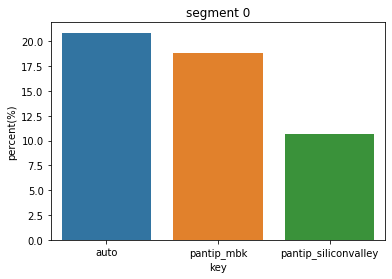

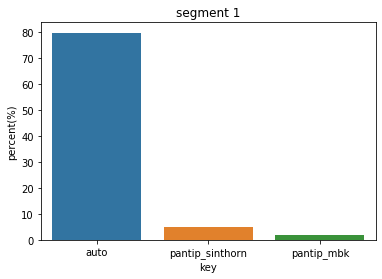

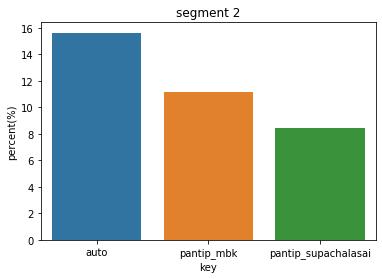

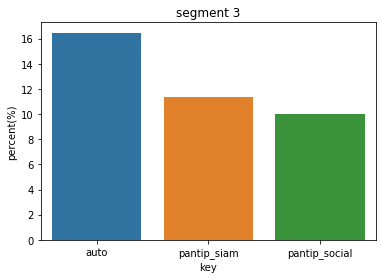

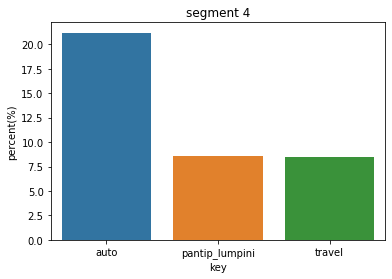

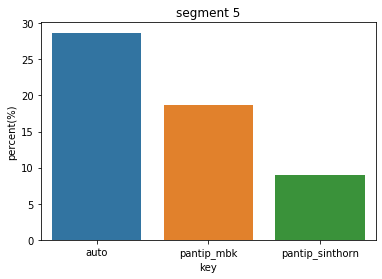

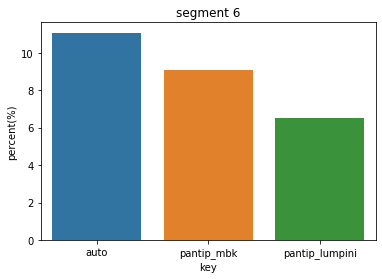

In [41]:
# visualize segment character
for i in range(7):
    df_plot = pd.DataFrame({'key':list(seg_character[i].keys()),'percent(%)':list(seg_character[i].values())})
    df_plot['percent(%)']=df_plot['percent(%)']*100
    sns.barplot(x='key',y='percent(%)',data=df_plot,).set_title(f'segment {df_segment.index[i]}')
    plt.show()
    df_plot.to_json(f'../tmp/segment_{df_segment.index[i]}.json')

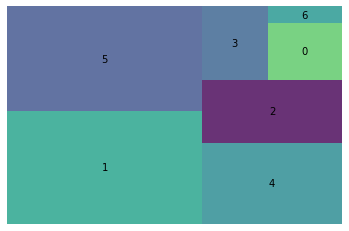

In [42]:
squarify.plot(sizes=df_user_segment_filt.segment_id.value_counts().values, label=df_user_segment_filt.segment_id.value_counts().index, alpha=.8 )
_=plt.axis('off')

In [43]:
segment_pop = df_user_segment_filt.segment_id.value_counts().reset_index()
segment_pop.columns = ['segment_id','population']
segment_pop.to_json('../tmp/segment_pop.json')